In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
from IPython.display import clear_output
import pickle
from datetime import datetime
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from google.colab import drive

import os

# Any results you write to the current directory are saved as output.

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def get_generator_model():

  x = keras.layers.Input(100)
  
  out = keras.layers.Dense(256)(x)
  out = keras.layers.LeakyReLU(0.2)(out)

  out = keras.layers.Dense(512)(out)
  out = keras.layers.LeakyReLU(0.2)(out)

  out = keras.layers.Dense(1024)(out)
  out = keras.layers.LeakyReLU(0.2)(out)

  out = keras.layers.Dense(784)(out)
  out = keras.layers.Activation('tanh', name='generated_image')(out)

  model = keras.Model(inputs=[x], outputs=[out])

  return model

In [0]:
def get_discriminator_model():

  x = keras.layers.Input(784)


  out = keras.layers.Dense(1024)(x)
  out = keras.layers.LeakyReLU(0.2)(out)
  out = keras.layers.Dropout(0.3)(out)

  out = keras.layers.Dense(512)(out)
  out = keras.layers.LeakyReLU(0.2)(out)
  out = keras.layers.Dropout(0.3)(out)

  out = keras.layers.Dense(256)(out)
  out = keras.layers.LeakyReLU(0.2)(out)
  out = keras.layers.Dropout(0.2)(out)

  out = keras.layers.Dense(1)(out)
  out = keras.layers.Activation('sigmoid', name='discriminator_result')(out)

  model = keras.Model(inputs=[x], outputs=[out])

  return model

In [0]:
def get_gan(generator, discriminator):

  gan_input = keras.layers.Input(shape=(100,))
  
  generated = generator(gan_input)
  gan_output= discriminator(generated)
  model = keras.Model(inputs=gan_input, outputs=gan_output)

  return model

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10), save_path='/content/'):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'gan_generated_image_{}.png'.format(epoch)))

In [7]:
generator = get_generator_model()
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
______________________________________________

In [8]:
discriminator = get_discriminator_model()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

In [9]:
gan = get_gan(generator, discriminator)
gan.summary()  

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Model)                (None, 784)               1486352   
_________________________________________________________________
model_1 (Model)              (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 2,946,577
Non-trainable params: 0
_________________________________________________________________


In [0]:
BATCH_SIZE = 160
EPOCHS = 100
SAMPLE_FREQUENCY = 20
SAVING_PATH = '/content/drive/My Drive/DCC/GAN_MNIST'

In [11]:
#Loading the data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_train = (X_train - 127.5) / 127.5
batch_count = int(X_train.shape[0] / BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


In [12]:
# Creating GAN
generator = get_generator_model()
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=2e-4, beta_1=0.5))

discriminator = get_discriminator_model()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=2e-4, beta_1=0.5))

discriminator.trainable=False

gan = get_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=2e-4, beta_1=0.5))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


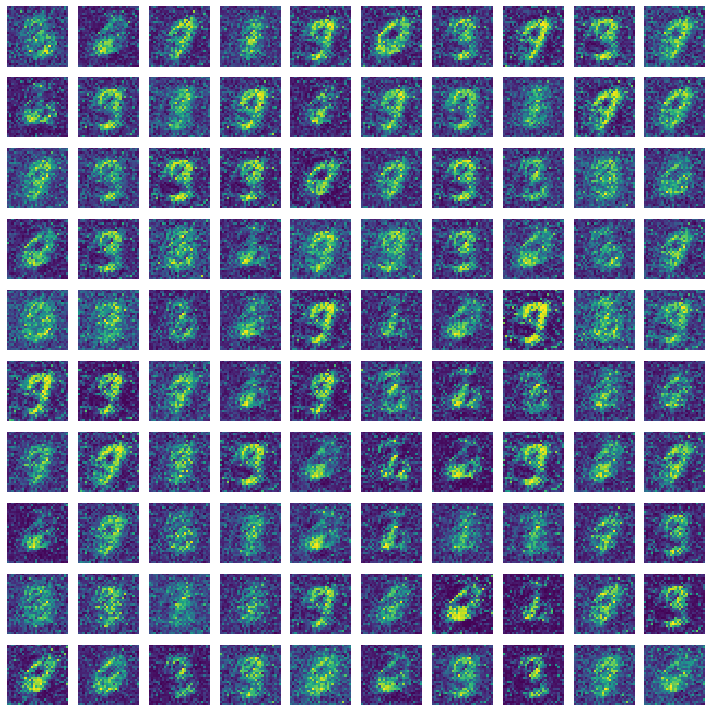

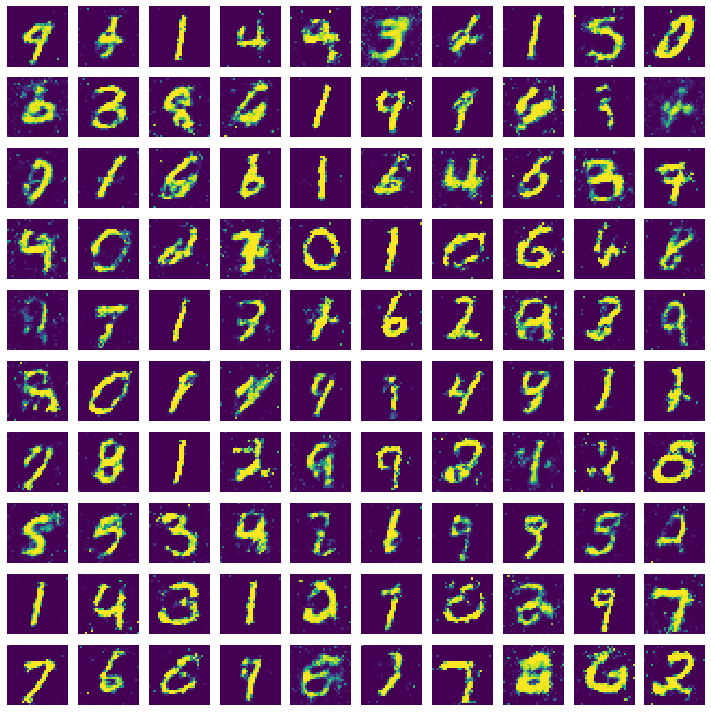

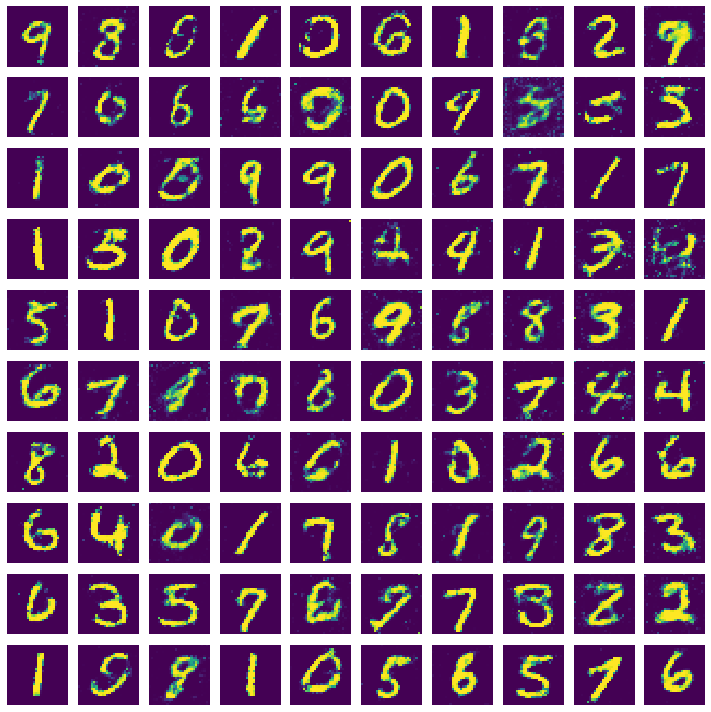

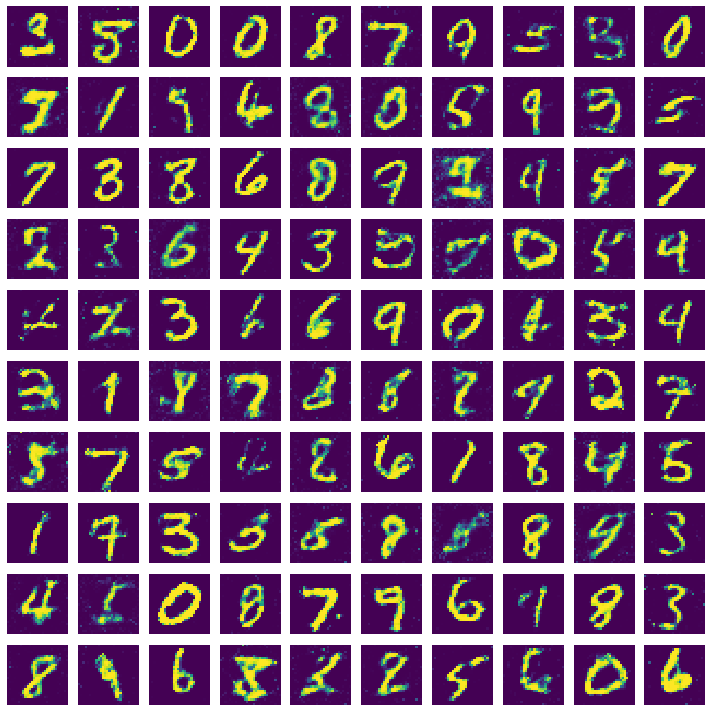

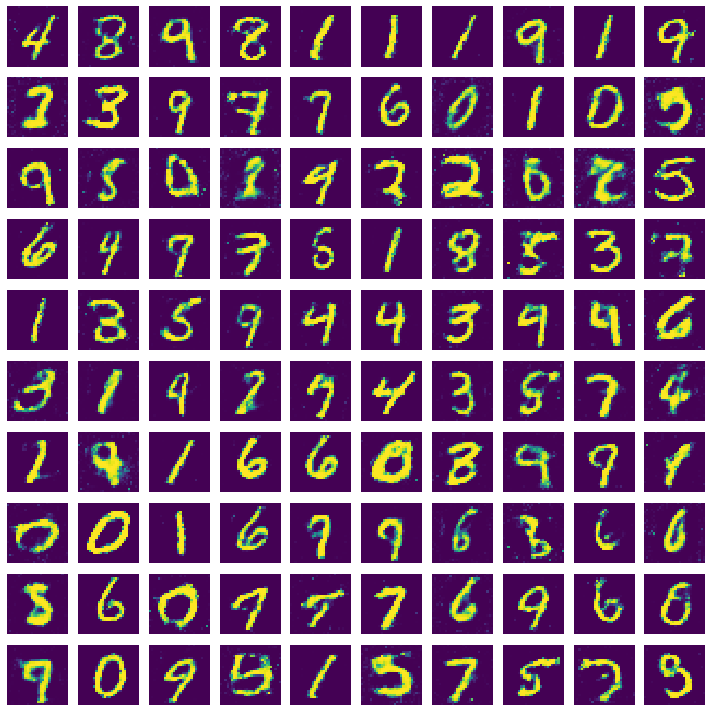

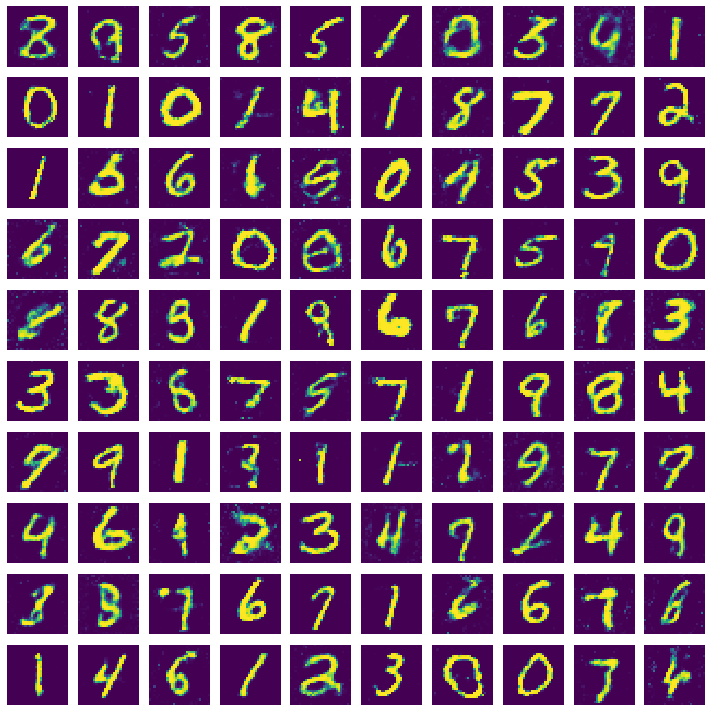

In [13]:
discriminator_loss = 0
generator_loss = 0

step_discriminator_loss = 0
step_generator_loss = 0

previous_steps = 0

# Training GAN
for epoch in range(1, EPOCHS + 1):

  best_generator_loss = 999999

  progress_bar = tqdm_notebook(range(batch_count))

  for batch_counter in progress_bar:

    progress_bar.set_postfix({
        'epoch': epoch,
        'discriminator_loss': step_discriminator_loss,
        'generator_loss': step_generator_loss
    })
    

    # generate  random noise as an input  to  initialize the  generator
    noise = np.random.normal(0,1, [BATCH_SIZE, 100])
            
    # Generate fake MNIST images from noised input
    generated_images = generator.predict(noise)
            
    # Get a random set of  real images
    image_batch = X_train[batch_counter * BATCH_SIZE: (batch_counter + 1) * BATCH_SIZE]
            
    #Construct different batches of  real and fake data 
    X = np.concatenate([image_batch, generated_images])
            
    # Labels for generated and real data
    # Set all labels in zeros
    labels = np.zeros(2 * BATCH_SIZE)
    # Correct labels for real images
    labels[:BATCH_SIZE] = 1
            
    # Pre train discriminator on  fake and real data  before starting the gan. 
    discriminator.trainable = True
    discriminator_loss += discriminator.train_on_batch(X, labels)
    
    # During the training of gan, 
    # the weights of discriminator should be fixed. 
    # We can enforce that by setting the trainable flag
    discriminator.trainable = False

    # Tricking the noised input of the Generator as real data
    noise = np.random.normal(0, 1, [BATCH_SIZE, 100])
    labels = np.ones(BATCH_SIZE)
            
    # training  the GAN by alternating the training of the Discriminator 
    # and training the chained GAN model with Discriminator’s weights freezed.
    generator_loss += gan.train_on_batch(noise, labels)


    step_discriminator_loss = discriminator_loss / (previous_steps + batch_counter + 1)
    step_generator_loss = generator_loss / (previous_steps + batch_counter + 1)

    
            
  if epoch == 1 or epoch % SAMPLE_FREQUENCY == 0:
    plot_generated_images(epoch, generator, save_path=SAVING_PATH)

  # Save model
  if step_generator_loss < best_generator_loss:
    best_generator_loss = step_generator_loss
    generator.save(os.path.join(SAVING_PATH, 'generator_model.h5'))

  
  
  previous_steps += batch_counter